In [1]:
!unzip '/content/drive/My Drive/14Class.zip'

Streaming output truncated to the last 5000 lines.
  inflating: 14Class/114117/00011.jpg  
  inflating: 14Class/114117/00021.jpg  
  inflating: 14Class/114117/00007.jpg  
  inflating: 14Class/114117/00009.jpg  
  inflating: 14Class/114117/00013.jpg  
  inflating: 14Class/114117/00005.jpg  
  inflating: 14Class/114117/00001.jpg  
   creating: 14Class/86074/
  inflating: 14Class/86074/00017.jpg  
  inflating: 14Class/86074/00015.jpg  
  inflating: 14Class/86074/00023.jpg  
  inflating: 14Class/86074/00019.jpg  
  inflating: 14Class/86074/00003.jpg  
  inflating: 14Class/86074/00011.jpg  
  inflating: 14Class/86074/00021.jpg  
  inflating: 14Class/86074/00007.jpg  
  inflating: 14Class/86074/00009.jpg  
  inflating: 14Class/86074/00013.jpg  
  inflating: 14Class/86074/00005.jpg  
  inflating: 14Class/86074/00001.jpg  
   creating: 14Class/28488/
  inflating: 14Class/28488/00017.jpg  
  inflating: 14Class/28488/00015.jpg  
  inflating: 14Class/28488/00023.jpg  
  inflating: 14Class/28488/0

In [2]:
import pandas as pd
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
import math
import random

In [3]:
LABELS={
    "Swiping Left":                     0,
    "Swiping Right":                    1,
    "Pulling Hand In":                  2,
    "Sliding Two Fingers Left":         3,
    "Sliding Two Fingers Right":        4,
    "Zooming In With Full Hand":        5,
    "Zooming In With Two Fingers":      6,
    "Zooming Out With Two Fingers":     7,
    "Thumb Up":                         8,
    "Thumb Down":                       9,
    "Stop Sign":                        10,
    "Drumming Fingers":                 11,
    "No gesture":                       12,
    "Doing other things":               13,

}

class readData():
    def __init__(self,
                 p_train='/content/drive/My Drive/csv14class/train.csv',
                 p_validation='/content/drive/My Drive/csv14class/valid.csv'):
        
        self.p_train      = p_train
        self.p_validation = p_validation
        self.readCSV()

    def readCSV(self):
        #Olusturulan pathlerden CSV dosyalarini okur
        print("Reading CSV Files")
        self.validationCSV = pd.read_csv(self.p_validation,header=None)
        self.trainCSV      = pd.read_csv(self.p_train,header=None)
        print("Reading CSV Files is Completed")

    def getDict(self):
        #Train ve Validation videolarının idlerini tutar
        #partition{'train': ['id-1', 'id-2', 'id-3'], 'validation': ['id-4']}
        #labels{'id-1': 0, 'id-2': 1, 'id-3': 2, 'id-4': 1}
        print("Creating Dictionaries")
        partition = {
            "train": self.trainCSV.get(0).values,
            "validation": self.validationCSV.get(0).values
        }
        labels={}
        print("Creating Train/Validation Labels")
        print("Adding Train Labels")
        for i in partition['train']:
            labels[i]=LABELS[self.trainCSV[self.trainCSV[0]==i][1].values[0]]
        print("Adding Validation Labels")
        for i in partition['validation']:
            labels[i]=LABELS[self.validationCSV[self.validationCSV[0]==i][1].values[0]]
        print("Completed")

        return partition,labels

In [4]:
class dataLoader(tf.keras.utils.Sequence):
    def __init__(self,list_IDs,labels,batchSize=16,dim=(12,150,100),nChannel=3,nClass=27,shuffle=True):
        self.dim = dim                  # Her batchte alınacak verinin boyutu Frame Sayısı * Width * Height
        self.batch_size = batchSize     # Batch boyutu
        self.labels = labels            # Classların labelları
        self.list_IDs = list_IDs        # Batch leri belirleyecek CSV train/validation csv
        self.n_channels = nChannel      # Resimdeki kanal sayısı RGB=3
        self.n_classes = nClass         # Class sayısı
        self.shuffle = shuffle          # Batchteki verileri karıştırır.
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # for dongusu icinde sonraki batch icin gesture örneklerini ve labellarını cek.
        # örnekleri ve altındaki tüm frameleri cekmek icin ekstra bir fonksiyona ihtiyac var.

        for i, ID in enumerate(list_IDs_temp):
            X[i] = self.sample_reader(ID)
            y[i] = self.labels[ID]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

    #Her bir videonun framelerini okur ve tek örnek döner
    #validation için ayrıca bir if else koyarak validation partitionda /valid den çek
    def sample_reader(self,id):
        # batchsize,framenumber,h,w,channel
        x = np.zeros((12, 150, 100, 3), dtype='uint8');
        i = 0
        for img in os.listdir('./14Class/' + str(id)):
            image = cv2.imread("./14Class/" + str(id) + "/" + str(img))
            image = cv2.resize(image, (100,150))
            x[i] = image
            i += 1
        return x

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):

        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [5]:
from tensorflow.keras.layers import ReLU,GlobalMaxPooling2D
from tensorflow.keras.layers import *

def createModel():
    model=tf.keras.Sequential()

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=32,padding='same',strides=1),input_shape=(12,150,100,3)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(1,1),data_format='channels_last')))

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=64,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(2,2),data_format='channels_last')))

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=128,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(2,2),data_format='channels_last')))

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=256,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=256,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(2,2),data_format='channels_last')))

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=512,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=512,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())
    
    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(2,2),data_format='channels_last')))


    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=1024,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(GlobalMaxPooling2D()))
    model.add(TimeDistributed(Dropout(0.2)))
    

    model.add(TimeDistributed(Dense(1024)))
    model.add(LSTM(1024))
    model.add(Dense(14,activation ='softmax'))


    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                      optimizer=tf.keras.optimizers.SGD(lr=0.01),
                      metrics=['accuracy'])
    model.summary()


    return model
createModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 150, 100, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 150, 100, 32)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 150, 100, 32)  128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 149, 99, 32)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 149, 99, 64)   18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 12, 149, 99, 64)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 149, 99, 64)   2

In [15]:
data_csv=readData()
partition,labels=data_csv.getDict()

training_data=dataLoader(partition['train'],labels,15,(12,150,100),3,14,True)
validation_data=dataLoader(partition['validation'],labels,15,(12,150,100),3,14,False)

Reading CSV Files
Reading CSV Files is Completed
Creating Dictionaries
Creating Train/Validation Labels
Adding Train Labels
Adding Validation Labels
Completed


In [7]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/Complete Models/14Class/model14class_{epoch:02d}.h5", monitor='acc', verbose=1,
                                                save_best_only=False, mode='auto',save_freq='epoch')

csv_logger = CSVLogger("/content/drive/My Drive/Complete Models/14Class/model14class_history_log.csv", append=True)

def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)



#model=createModel()
model=tf.keras.models.load_model("/content/drive/My Drive/Complete Models/14Class/model14class_02.h5")


model.fit(x=training_data,
                    validation_data=validation_data,
                    epochs=50,callbacks=[checkpoint,csv_logger,lrate],verbose=1,initial_epoch=2)



Epoch 3/50
4342/4342 [==============================] - ETA: 0s - loss: 0.8417 - accuracy: 0.7279
Epoch 00003: saving model to /content/drive/My Drive/Complete Models/14Class/model14class_03.h5
4342/4342 [==============================] - 1935s 446ms/step - loss: 0.8417 - accuracy: 0.7279 - val_loss: 1.0781 - val_accuracy: 0.6593 - lr: 0.0100
Epoch 4/50
4342/4342 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.8070
Epoch 00004: saving model to /content/drive/My Drive/Complete Models/14Class/model14class_04.h5
4342/4342 [==============================] - 1936s 446ms/step - loss: 0.6051 - accuracy: 0.8070 - val_loss: 0.6393 - val_accuracy: 0.8029 - lr: 0.0100
Epoch 5/50
4342/4342 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.8500
Epoch 00005: saving model to /content/drive/My Drive/Complete Models/14Class/model14class_05.h5
4342/4342 [==============================] - 1941s 447ms/step - loss: 0.4725 - accuracy: 0.8500 - val_loss: 0.5154 -

KeyboardInterrupt: ignored

#Evaluate


In [16]:
model=tf.keras.models.load_model("/content/drive/My Drive/Complete Models/14Class/model14class_11.h5")
y_pred = model.predict_generator(validation_data,550,verbose=1)
y_pred = np.argmax(y_pred,axis=1)

550/550 [==============================] - 78s 142ms/step


In [17]:
y_pred

array([11, 12, 12, ..., 11,  2,  6])

In [18]:
y_true=pd.read_csv("/content/drive/My Drive/csv14class/valid.csv",header=None)[1].values[0:8250]
for i,label in enumerate(y_true):
  y_true[i] = LABELS[label]

y_true

array([11, 12, 12, ..., 11, 2, 6], dtype=object)

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true2=np.array(y_true,dtype=np.uint32)
y_pred2=np.array(y_pred,dtype=np.uint32)

print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83       493
           1       0.87      0.81      0.84       483
           2       0.91      0.92      0.91       523
           3       0.86      0.91      0.89       518
           4       0.90      0.87      0.88       516
           5       0.92      0.88      0.90       526
           6       0.87      0.83      0.85       522
           7       0.91      0.88      0.90       529
           8       0.93      0.93      0.93       538
           9       0.93      0.94      0.93       536
          10       0.97      0.95      0.96       535
          11       0.90      0.95      0.93       533
          12       0.74      0.95      0.84       532
          13       0.88      0.84      0.86      1466

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



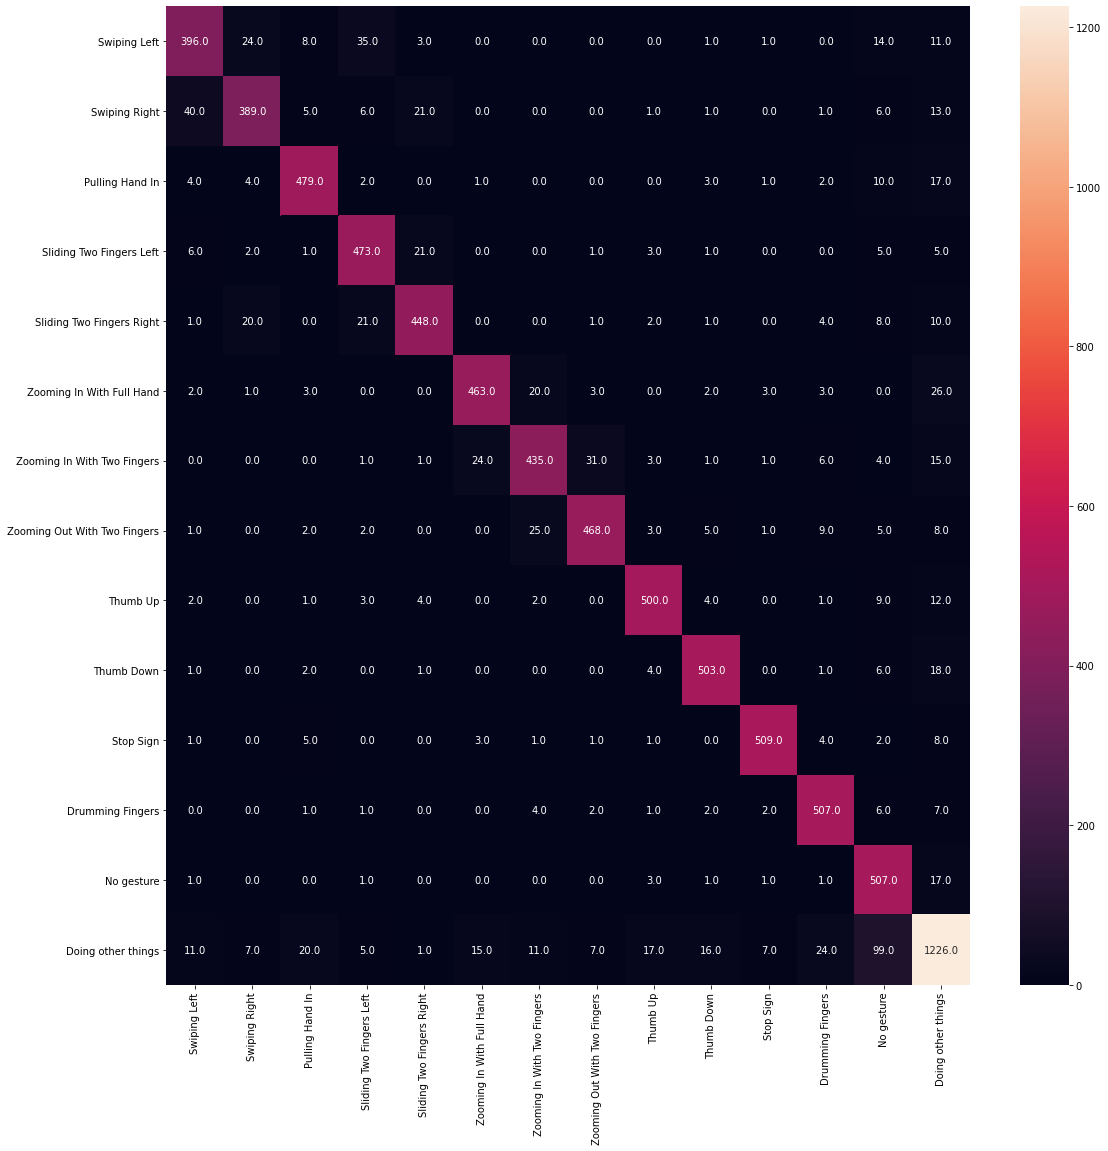

In [24]:
LABELS2=[
    "Swiping Left",
    "Swiping Right",
    "Pulling Hand In",
    "Sliding Two Fingers Left",
    "Sliding Two Fingers Right",
    "Zooming In With Full Hand",
    "Zooming In With Two Fingers",
    "Zooming Out With Two Fingers",
    "Thumb Up",
    "Thumb Down",
    "Stop Sign",
    "Drumming Fingers",
    "No gesture",
    "Doing other things",
]
matrix = confusion_matrix(y_true2, y_pred2)
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, xticklabels=True, yticklabels=True,fmt=".1f")
ax.figure.set_size_inches(18,18)
ax.xaxis.set_ticklabels(LABELS2,rotation=90); ax.yaxis.set_ticklabels(LABELS2,rotation=0);
